# 此份代码来源
https://www.kaggle.com/aralsarrafi/flowers-resnet50-tensorflow
# 待学习链接
https://blog.csdn.net/wf592523813/article/details/94478006?utm_medium=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.channel_param&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.channel_param

https://www.baidu.com/link?url=5VywaI7fOaH1nVJXM8oTTZ5fO_bTA2WtSrEMOdY_YrfcGDTpAQ3wSwNdIBnaIAnOeOiv9Y4EJo4xhASOcJCnra&wd=&eqid=a9c857cc000428a7000000065faf5585

https://www.cnblogs.com/hutao722/p/10008581.html 【从这里来看，依然是个尝试的过程？】

https://www.zhihu.com/question/273633408/answer/369134332 【关于ImageNet数据集】

https://www.cnblogs.com/BlueBlueSea/p/11067521.html 【对于dropout的别人的尝试】

https://blog.csdn.net/qq_27292549/article/details/81092653 【不确定值不值得看，大概率不值得】

In [1]:
import numpy as np
np.random.seed(42)
import tensorflow.compat.v1 as tf
import keras as K
import pandas as pd
import os

os.environ['CUDA_VISIBLE_DEVICES']='7'
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras import backend
# from numba import cuda
from keras.models import load_model
import time 
%matplotlib inline 

Using TensorFlow backend.


In [2]:
# import tensorflow as tf # tf.__version__ == 2.1.0, keras.__version__ == 2.3.1
# https://blog.csdn.net/u012388993/article/details/102573008
# import keras.backend.tensorflow_backend as ktf
# https://blog.csdn.net/zuoyouzouzou/article/details/104329286
import tensorflow.compat.v1 as tf
import tensorflow.compat.v1.keras.backend as ktf

# GPU 显存自动调用
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
ktf.set_session(session)

In [3]:
train_path = r'flowers_google'
labels_path = "flowers_label.csv"
ids_path = "flowers_idx.csv"

In [4]:
def PrepareAnnotation(ids_path, labels_path, train_path):
    
    ids = pd.read_csv(ids_path)
    labels  = pd.read_csv(labels_path)
    
    annotation_dict = {}

    for i in range(len(ids['id'])):
        image_id = ids['id'][i]
        image_lable = ids['flower_cls'][i]
        annotation_dict[image_id] = image_lable
    
    label_dict = {}
    num_classes = 0

    for i in range(len(labels['flower_class'])):
        label_dict[labels['flower_class'][i]] = labels['label'][i]
        num_classes+=1
        
    for key, value in annotation_dict.items():
        annotation_dict[key] = label_dict[value]
    
    image_pathes = []
    targets = []
    
    for key, value in annotation_dict.items():
        
        image_name = str(key) + ".jpeg"
        image_path = os.path.join(train_path, image_name)
        image_pathes.append(image_path)
        targets.append(value)
    
    return image_pathes, targets, num_classes

In [5]:
image_pathes, targets, num_classes = PrepareAnnotation(ids_path, labels_path, train_path)

In [6]:
val_ratio = 0.2
x_train, x_val, y_train, y_val = train_test_split(image_pathes, targets, test_size=val_ratio, random_state=42, shuffle = True, stratify = targets)
print("num_train = ", len(x_train))
print("num_valid = ", len(x_val))

num_train =  13172
num_valid =  3293


In [7]:
def SelectSamplesForEachClass(x_train, y_train, num_examples):
    class_image_path = {}
    
    for i in range(len(y_train)):
        if (y_train[i] in class_image_path):
            if len(class_image_path[y_train[i]]) < num_examples:
                   class_image_path[y_train[i]].append(x_train[i])
        
        else:
            class_image_path[y_train[i]] = [x_train[i]]        
    
    return class_image_path

# 仅仅是展示数据集中的某些图像

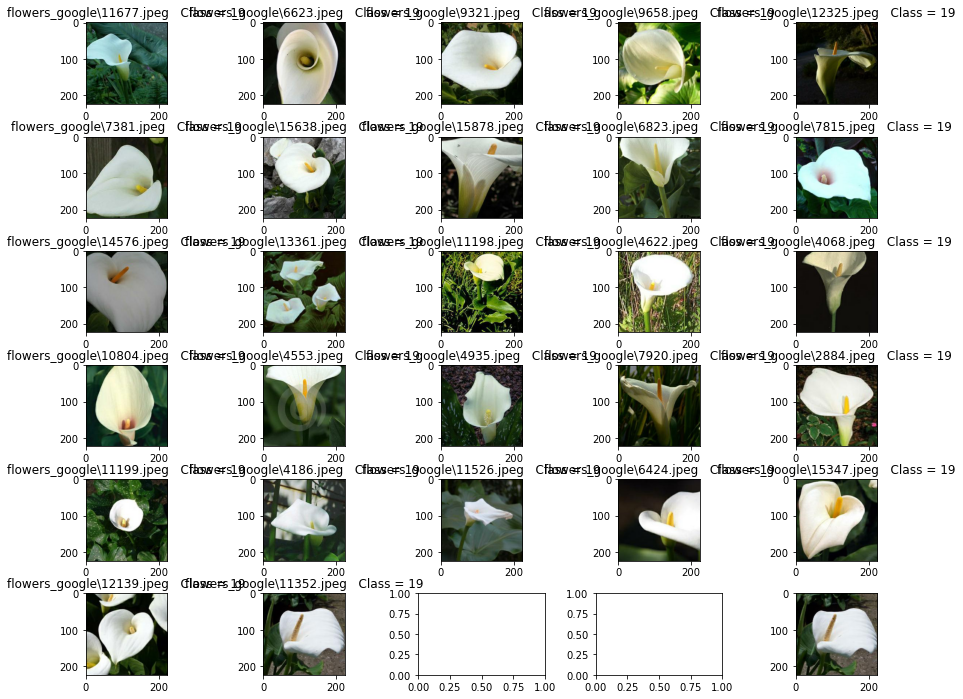

In [8]:
class_label = 19 # Try other Classes.
num_examples_to_show = 30

class_image_path_ = SelectSamplesForEachClass(x_train, y_train, num_examples_to_show)

images = class_image_path_[class_label]

fig, ax = plt.subplots(6,5, figsize=(15,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

ax = ax.ravel()
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img)
    
    plt.imshow(img)
    
    title_txt = image.split("/")[-1] + "   " + "Class = " + str(class_label)
    ax[i].set_title(title_txt)
    i+=1

In [9]:
def Generator(X, Y, batch_size=16, mode='test'):
    iter_index=0
    while True:
        if mode=='test':
            index_end = min((iter_index+1)*batch_size,len(X))
            indexes = np.arange(iter_index*batch_size,index_end)
            if (iter_index+1)*batch_size >= len(X):  # 防止下一个epoch崩溃
                iter_index = 0

            iter_index+=1
        else:
            indexes = np.random.choice(len(X), batch_size)
        x = []
        y = []
    
        for index in indexes:
            x.append(X[index]) 
            y.append(Y[index])
        
        x_batch = []
        
        y_batch = K.utils.to_categorical(y, num_classes= num_classes)
        
        for i in range(len(x)):
            image = cv2.imread(x[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = K.applications.resnet50.preprocess_input(image)
            x_batch.append(image)
        
        x_batch = np.array(x_batch)
        
        yield x_batch, y_batch

In [10]:
def ResNet50Model():
    model = K.applications.ResNet50(include_top=False, weights="imagenet", input_shape =(224, 224, 3))
    
    new_output = K.layers.GlobalAveragePooling2D()(model.output)
    new_output = K.layers.Dense(num_classes, activation = 'softmax')(new_output)
    
    model = K.engine.training.Model(model.inputs, new_output)
    
    return model

In [11]:
model = ResNet50Model()

C:\Users\Admin\anaconda3\envs\keras\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [12]:
# Freez first 168 Layers Except the Batch Normalization ones.
num_feerezed_layer = 168

for layer in model.layers:
    layer.trainable = True
    
    if isinstance(layer, K.layers.BatchNormalization):
        # Set Batch Norm momentun to 0.9 to faster adapt to the new DataSet.
        layer.momentum = 0.9

for layer in model.layers[:num_feerezed_layer]:
    
    if not isinstance(layer, K.layers.BatchNormalization):
        layer.trainable = False
        
# Check if the trainable layers are set Correctly
# for layer in model.layers:
#     print(layer.name, " ", "trainable = ", layer.trainable)

In [13]:
batch_size = 128 # Tesla 上占用31441MB
model_root = 'models/models_'+str(batch_size)
checkpoint = ModelCheckpoint(os.path.join(model_root,'Best_Model.h5'),
                             verbose=1, monitor='val_accuracy',save_best_only=True, mode='max')

In [14]:
model.compile(loss='categorical_crossentropy', optimizer = K.optimizers.Adamax(lr=0.01), metrics=['accuracy'])

In [15]:
from tqdm import tqdm 

if not os.path.exists(model_root):
    os.makedirs(model_root)
    
train_losses = [] 
train_accs = [] 
test_losses = []
test_accs = [] 
train_indices = [] 
test_indices = [] 
test_loss_temp_restore = [] 
test_acc_temp_restore = []
best_acc = 0
batch_num = np.ceil(len(x_train)/batch_size)
index = 0

time_begin = time.time()
for epoch in range(6):
    train_generator = Generator(x_train, y_train, batch_size)
    test_generator = Generator(x_val, y_val, 4*batch_size)
    bar = tqdm(total = batch_num, ncols=90)
    for batch, label in train_generator:
        bar.set_description_str(f'{epoch+1}/6epochs')

        index += 1
        train_loss, train_acc = model.train_on_batch(batch, label)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_indices.append(index)
        if (index-1)%30==0:
            test_loss=test_acc=0
            test_times = np.ceil(len(x_val)/4/batch_size)
#             bar_test = tqdm(total=test_times, ncols = 90)
            bar.set_description_str('val')
            test_loss_temp_ls = []
            test_acc_temp_ls = []
            for test_index in range(int(test_times)):
                batch, label = next(test_generator)
                test_loss_temp, test_acc_temp = model.test_on_batch(batch, label)
                test_loss_temp_ls.append(test_loss_temp)
                test_acc_temp_ls.append(test_acc_temp)
                test_loss+=test_loss_temp 
                test_acc+=test_acc_temp
                bar.set_postfix_str('loss:{:.2f}, acc:{:.2f}%'.format(test_loss_temp,test_acc_temp*100))
#                 bar_test.update(1)
                if test_index == test_times-1:
                    break
            test_loss_temp_restore.append(test_loss_temp_ls)
            test_acc_temp_restore.append(test_acc_temp_ls)
            test_loss = test_loss/test_times
            test_acc = test_acc/test_times
            test_losses.append(test_loss)
            test_accs.append(test_acc)
            test_indices.append(index)
            
            
            if test_acc > 0.8 and test_acc >= best_acc:
                model.save(os.path.join(model_root, 'flower_{}_{}_{:.4f}.h5'.format(epoch, index, test_acc)))
                model.save(os.path.join(model_root, 'Best_Model.h5'))
                best_acc = test_acc
        bar.set_postfix_str('loss:{:.2f}, acc:{:.2f}%'.format(train_loss,train_acc*100))
        bar.update(1)
        if index % batch_num == 0:
            bar.moveto(0)
            break
time_end = time.time()
# model.fit(Generator(x_train, y_train, batch_size), 
#           steps_per_epoch=len(x_train)//batch_size,
#           epochs= 4,
#           validation_data=Generator(x_val, y_val, batch_size),
#           validation_steps=len(x_val) // batch_size,
#           callbacks=[checkpoint])

1/6epochs: 100%|███████████████| 103/103.0 [02:58<00:00,  1.25s/it, loss:0.70, acc:85.34%]
1/6epochs: 100%|███████████████| 103/103.0 [02:58<00:00,  1.74s/it, loss:0.70, acc:85.34%]

2/6epochs:   0%|                                                | 0/103.0 [00:00<?, ?it/s]
2/6epochs:   0%|                         | 0/103.0 [00:00<?, ?it/s, loss:0.21, acc:93.75%]
2/6epochs:   1%|▏                | 1/103.0 [00:00<01:28,  1.15it/s, loss:0.21, acc:93.75%]
2/6epochs:   1%|▏                | 1/103.0 [00:01<01:28,  1.15it/s, loss:0.21, acc:93.75%]
2/6epochs:   1%|▏                | 1/103.0 [00:01<01:28,  1.15it/s, loss:0.20, acc:96.88%]
2/6epochs:   2%|▎                | 2/103.0 [00:01<01:39,  1.02it/s, loss:0.20, acc:96.88%]
2/6epochs:   2%|▎                | 2/103.0 [00:02<01:39,  1.02it/s, loss:0.20, acc:96.88%]
2/6epochs:   2%|▎                | 2/103.0 [00:02<01:39,  1.02it/s, loss:0.24, acc:96.09%]
2/6epochs:   3%|▍                | 3/103.0 [00:02<01:31,  1.09it/s, loss:0.24, acc:96.09%

2/6epochs:  50%|████████        | 52/103.0 [01:14<01:48,  2.12s/it, loss:0.25, acc:93.75%]
2/6epochs:  50%|████████        | 52/103.0 [01:15<01:48,  2.12s/it, loss:0.28, acc:90.62%]
2/6epochs:  51%|████████▏       | 53/103.0 [01:15<01:27,  1.75s/it, loss:0.28, acc:90.62%]
2/6epochs:  51%|████████▏       | 53/103.0 [01:15<01:27,  1.75s/it, loss:0.28, acc:90.62%]
2/6epochs:  51%|████████▏       | 53/103.0 [01:16<01:27,  1.75s/it, loss:0.32, acc:92.97%]
2/6epochs:  52%|████████▍       | 54/103.0 [01:16<01:12,  1.48s/it, loss:0.32, acc:92.97%]
2/6epochs:  52%|████████▍       | 54/103.0 [01:16<01:12,  1.48s/it, loss:0.32, acc:92.97%]
2/6epochs:  52%|████████▍       | 54/103.0 [01:17<01:12,  1.48s/it, loss:0.26, acc:92.97%]
2/6epochs:  53%|████████▌       | 55/103.0 [01:17<01:01,  1.29s/it, loss:0.26, acc:92.97%]
2/6epochs:  53%|████████▌       | 55/103.0 [01:17<01:01,  1.29s/it, loss:0.26, acc:92.97%]
2/6epochs:  53%|████████▌       | 55/103.0 [01:17<01:01,  1.29s/it, loss:0.36, acc:92.19%]

4/6epochs:   4%|▌               | 4/103.0 [00:03<01:30,  1.09it/s, loss:0.02, acc:100.00%]
4/6epochs:   4%|▌               | 4/103.0 [00:03<01:30,  1.09it/s, loss:0.02, acc:100.00%]
4/6epochs:   4%|▌               | 4/103.0 [00:04<01:30,  1.09it/s, loss:0.03, acc:100.00%]
4/6epochs:   5%|▊               | 5/103.0 [00:04<01:29,  1.10it/s, loss:0.03, acc:100.00%]
4/6epochs:   5%|▊               | 5/103.0 [00:04<01:29,  1.10it/s, loss:0.03, acc:100.00%]
4/6epochs:   5%|▊               | 5/103.0 [00:05<01:29,  1.10it/s, loss:0.03, acc:100.00%]
4/6epochs:   6%|▉               | 6/103.0 [00:05<01:28,  1.10it/s, loss:0.03, acc:100.00%]
4/6epochs:   6%|▉               | 6/103.0 [00:05<01:28,  1.10it/s, loss:0.03, acc:100.00%]
4/6epochs:   6%|▉               | 6/103.0 [00:06<01:28,  1.10it/s, loss:0.02, acc:100.00%]
4/6epochs:   7%|█               | 7/103.0 [00:06<01:27,  1.09it/s, loss:0.02, acc:100.00%]
4/6epochs:   7%|█               | 7/103.0 [00:06<01:27,  1.09it/s, loss:0.02, acc:100.00%]

4/6epochs:  54%|████████▏      | 56/103.0 [01:18<01:42,  2.19s/it, loss:0.02, acc:100.00%]
4/6epochs:  55%|████████▎      | 57/103.0 [01:18<01:22,  1.79s/it, loss:0.02, acc:100.00%]
4/6epochs:  55%|████████▎      | 57/103.0 [01:19<01:22,  1.79s/it, loss:0.02, acc:100.00%]
4/6epochs:  55%|████████▊       | 57/103.0 [01:19<01:22,  1.79s/it, loss:0.02, acc:99.22%]
4/6epochs:  56%|█████████       | 58/103.0 [01:19<01:07,  1.51s/it, loss:0.02, acc:99.22%]
4/6epochs:  56%|█████████       | 58/103.0 [01:19<01:07,  1.51s/it, loss:0.02, acc:99.22%]
4/6epochs:  56%|████████▍      | 58/103.0 [01:20<01:07,  1.51s/it, loss:0.02, acc:100.00%]
4/6epochs:  57%|████████▌      | 59/103.0 [01:20<00:57,  1.31s/it, loss:0.02, acc:100.00%]
4/6epochs:  57%|████████▌      | 59/103.0 [01:20<00:57,  1.31s/it, loss:0.02, acc:100.00%]
4/6epochs:  57%|████████▌      | 59/103.0 [01:21<00:57,  1.31s/it, loss:0.02, acc:100.00%]
4/6epochs:  58%|████████▋      | 60/103.0 [01:21<00:50,  1.18s/it, loss:0.02, acc:100.00%]

6/6epochs:   8%|█▎               | 8/103.0 [00:06<01:20,  1.18it/s, loss:0.01, acc:99.22%]
6/6epochs:   8%|█▏              | 8/103.0 [00:07<01:20,  1.18it/s, loss:0.01, acc:100.00%]
6/6epochs:   9%|█▍              | 9/103.0 [00:07<01:19,  1.18it/s, loss:0.01, acc:100.00%]
6/6epochs:   9%|█▍              | 9/103.0 [00:07<01:19,  1.18it/s, loss:0.01, acc:100.00%]
6/6epochs:   9%|█▍              | 9/103.0 [00:08<01:19,  1.18it/s, loss:0.01, acc:100.00%]
6/6epochs:  10%|█▍             | 10/103.0 [00:08<01:18,  1.18it/s, loss:0.01, acc:100.00%]
6/6epochs:  10%|█▍             | 10/103.0 [00:08<01:18,  1.18it/s, loss:0.01, acc:100.00%]
6/6epochs:  10%|█▍             | 10/103.0 [00:09<01:18,  1.18it/s, loss:0.01, acc:100.00%]
6/6epochs:  11%|█▌             | 11/103.0 [00:09<01:17,  1.18it/s, loss:0.01, acc:100.00%]
6/6epochs:  11%|█▌             | 11/103.0 [00:09<01:17,  1.18it/s, loss:0.01, acc:100.00%]
6/6epochs:  11%|█▌             | 11/103.0 [00:10<01:17,  1.18it/s, loss:0.01, acc:100.00%]

6/6epochs:  59%|████████▉      | 61/103.0 [01:13<00:59,  1.41s/it, loss:0.00, acc:100.00%]
6/6epochs:  59%|████████▉      | 61/103.0 [01:13<00:59,  1.41s/it, loss:0.00, acc:100.00%]
6/6epochs:  59%|████████▉      | 61/103.0 [01:14<00:59,  1.41s/it, loss:0.00, acc:100.00%]
6/6epochs:  60%|█████████      | 62/103.0 [01:14<00:50,  1.24s/it, loss:0.00, acc:100.00%]
6/6epochs:  60%|█████████      | 62/103.0 [01:14<00:50,  1.24s/it, loss:0.00, acc:100.00%]
6/6epochs:  60%|█████████      | 62/103.0 [01:15<00:50,  1.24s/it, loss:0.01, acc:100.00%]
6/6epochs:  61%|█████████▏     | 63/103.0 [01:15<00:45,  1.13s/it, loss:0.01, acc:100.00%]
6/6epochs:  61%|█████████▏     | 63/103.0 [01:15<00:45,  1.13s/it, loss:0.01, acc:100.00%]
6/6epochs:  61%|█████████▏     | 63/103.0 [01:16<00:45,  1.13s/it, loss:0.00, acc:100.00%]
6/6epochs:  62%|█████████▎     | 64/103.0 [01:16<00:41,  1.06s/it, loss:0.00, acc:100.00%]
6/6epochs:  62%|█████████▎     | 64/103.0 [01:16<00:41,  1.06s/it, loss:0.00, acc:100.00%]

In [16]:
print('time used is', (time_end-time_begin)/60)

history_root = 'history/history_'+str(batch_size)
if not os.path.exists(history_root):
    os.makedirs(history_root)
    
for i in ['train_losses','train_accs','test_losses','test_accs',
          'train_indices','test_indices','test_loss_temp_restore',
          'test_acc_temp_restore']:
    np.save(os.path.join(history_root,i), eval(i))

time used is 14.799545788764954


In [17]:
model = load_model(os.path.join(model_root, "Best_Model.h5"))
test_accuracy = model.evaluate_generator(Generator(x_val, y_val, batch_size), len(x_val) // batch_size)[1]
print(test_accuracy)

0.8812500238418579


In [18]:
def VisualizePrediction(path, gt_label):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image)
    
    image = K.applications.resnet50.preprocess_input(image)
    image = np.expand_dims(image, axis = 0)
    
    probabilities = model.predict(image)
    predicted_label = np.argmax(probabilities, axis = 1)
    
    title_txt = "Prediction = " + str(predicted_label[0]) + "     " + "gt = " + str(gt_label)
    plt.title(title_txt)

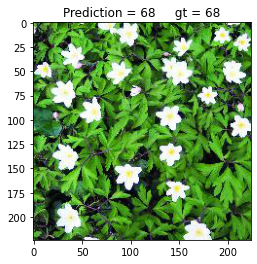

In [19]:
sample = 500 # Try different Samples
image_path = x_val[sample]
gt_label = y_val[sample]

# Make Predictions on Training Data set.
# image_path = x_train[sample]
# gt_label = y_train[sample]

VisualizePrediction(image_path, gt_label)

# 训练曲线可视化

In [20]:
import numpy as np 
from matplotlib import pyplot as plt 
%matplotlib inline 

train_losses = np.load(os.path.join(history_root,'train_losses.npy'),allow_pickle =True)
train_accs = np.load(os.path.join(history_root,'train_accs.npy'),allow_pickle=True)
test_losses = np.load(os.path.join(history_root, 'test_losses.npy'),allow_pickle=True)
test_accs = np.load(os.path.join(history_root,'test_accs.npy'),allow_pickle=True)
train_indices = np.load(os.path.join(history_root, 'train_indices.npy'),allow_pickle=True)
test_indices = np.load(os.path.join(history_root, 'test_indices.npy'),allow_pickle=True)

In [21]:
# plt.plot(train_losses)
# plt.plot(np.arange(1,min(len(train_losses),len(test_accs)*30)+1,30),test_losses,'red',label='test')

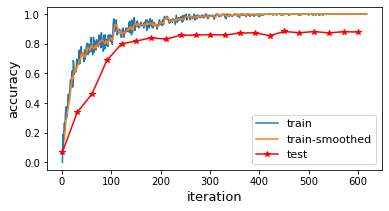

In [22]:
plt.figure(figsize = (6,3))
plt.plot(np.arange(1,len(train_accs)+1),train_accs,label='train')

train_accs_smoothing = [] 
smooth_num = 5
for i in range(len(train_accs)-smooth_num):
    begin_index = i
    end_index = i+smooth_num
    temp = train_accs[begin_index:end_index]
    train_accs_smoothing.append(np.mean(temp))
plt.plot(np.arange(smooth_num,len(train_accs)),train_accs_smoothing,label='train-smoothed')
plt.plot(np.arange(1,min(len(train_accs),len(test_accs-1)*30+1)+1,30),test_accs,'r-*',label='test')
# test_accs = np.load(os.path.join('history/history_64_noperfect','test_accs.npy'),allow_pickle=True)
# plt.plot(np.arange(1,min(len(train_accs),len(test_accs-1)*30+1)+1,30),test_accs,'g-*',label='test')

plt.legend(fontsize=11)
plt.ylabel('accuracy',fontsize=13)
plt.xlabel('iteration',fontsize=13)
# plt.xlim(0,4000)
plt.savefig('curves.png',dpi=200,bbox_inches='tight')